In [71]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hdbscan
import umap
from sklearn.manifold import TSNE

In [72]:
torch.manual_seed(42)
np.random.seed(42)

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [74]:
config = {
    'batch_size': 128,
    'latent_dim': 32,
    'image_size': (256, 256),  # Updated to 256x256 as requested
    'epochs': 50,
    'lr': 1e-3,
    'beta': 200,  # Weight for KL divergence
}

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(config['image_size']),  
    transforms.RandomRotation(15),  # Rotate the image randomly
    transforms.RandomResizedCrop(size=(config['image_size']), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),  # Optionally flip vertically
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.RandomAffine(degrees=0, shear=20),
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [76]:
base_folder = os.path.join("..", "Merged Files")
my_data = []

for i in os.listdir(base_folder):
    img_path = os.path.join(base_folder, i)
    image = Image.open(img_path).convert("RGB")
    image_T = data_transform(image)
    my_data.append(image_T.unsqueeze(0))

data = torch.cat(my_data, dim=0).to(device)
print(f"Dataset shape: {data.shape}")

Dataset shape: torch.Size([1115, 3, 256, 256])


In [77]:
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

In [78]:
# class BetaVAE(nn.Module):
#     def __init__(self, latent_dim=config['latent_dim'], beta=config['beta']):
#         super(BetaVAE, self).__init__()
#         self.latent_dim = latent_dim
#         self.beta = beta  # Regularization strength parameter for β-VAE
        
#         # Encoder
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
#         self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        
#         # Calculate size after convolutions
#         self.fc_size = 512 * 8 * 8
        
#         # Latent representation
#         self.fc_mu = nn.Linear(self.fc_size, latent_dim)
#         self.fc_logvar = nn.Linear(self.fc_size, latent_dim)
        
#         # Decoder
#         self.fc_decoder = nn.Linear(latent_dim, self.fc_size)
        
#         self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
#         self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
#         self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
#         self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
#         self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        
#         # Batch normalization for better training stability
#         self.bn1 = nn.BatchNorm2d(32)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.bn4 = nn.BatchNorm2d(256)
#         self.bn5 = nn.BatchNorm2d(512)
        
#         self.bn6 = nn.BatchNorm2d(256)
#         self.bn7 = nn.BatchNorm2d(128)
#         self.bn8 = nn.BatchNorm2d(64)
#         self.bn9 = nn.BatchNorm2d(32)
    
#     def encode(self, x):
#         # Encoder forward pass
#         x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
#         x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
#         x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
#         x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
#         x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2)

#         x = x.view(-1, self.fc_size)
        
#         # Return mean and log variance of the latent distribution
#         mu = self.fc_mu(x)
#         logvar = self.fc_logvar(x)
#         return mu, logvar
    
#     def reparameterize(self, mu, logvar):
#         # Reparameterization trick
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         z = mu + eps * std
#         return z
    
#     def decode(self, z):
#         # Decoder forward pass
#         x = F.leaky_relu(self.fc_decoder(z), 0.2)
#         x = x.view(-1, 512, 8, 8)
        
#         x = F.leaky_relu(self.bn6(self.deconv1(x)), 0.2)
#         x = F.leaky_relu(self.bn7(self.deconv2(x)), 0.2)
#         x = F.leaky_relu(self.bn8(self.deconv3(x)), 0.2)
#         x = F.leaky_relu(self.bn9(self.deconv4(x)), 0.2)
#         x = torch.tanh(self.deconv5(x))  # Output in range [-1, 1]
#         return x
    
#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         x_recon = self.decode(z)
#         return x_recon, mu, logvar
    
#     def loss_function(self, recon_x, x, mu, logvar):
#         # Reconstruction loss (MSE)
#         recon_loss = F.mse_loss(recon_x, x, reduction='sum')
        
#         # KL divergence loss
#         kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
#         # Total loss with beta weighting for stronger regularization
#         return recon_loss + self.beta * kl_loss, recon_loss, kl_loss

In [ ]:
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=config['latent_dim'], beta=config['beta']):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta  # Regularization strength parameter for β-VAE
        
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        
        # Calculate size after convolutions
        self.fc_size = 512 * 8 * 8
        
        # Latent representation
        self.fc_mu = nn.Linear(self.fc_size, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_size, latent_dim)
        
        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.fc_size)
        
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        
        # Batch normalization for better training stability
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.bn6 = nn.BatchNorm2d(256)
        self.bn7 = nn.BatchNorm2d(128)
        self.bn8 = nn.BatchNorm2d(64)
        self.bn9 = nn.BatchNorm2d(32)
    
    def encode(self, x):
        # Encoder forward pass
        x = F.gelu(self.bn1(self.conv1(x)))
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        x = F.gelu(self.bn4(self.conv4(x)))
        x = F.gelu(self.bn5(self.conv5(x)))

        x = x.view(-1, self.fc_size)
        
        # Return mean and log variance of the latent distribution
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        # Decoder forward pass
        x = F.gelu(self.fc_decoder(z))
        x = x.view(-1, 512, 8, 8)
        
        x = F.gelu(self.bn6(self.deconv1(x)))
        x = F.gelu(self.bn7(self.deconv2(x)))
        x = F.gelu(self.bn8(self.deconv3(x)))
        x = F.gelu(self.bn9(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))  # Output in range [-1, 1]
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar):
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Total loss with beta weighting for stronger regularization
        return recon_loss + self.beta * kl_loss, recon_loss, kl_loss


In [80]:
model = BetaVAE(latent_dim=config['latent_dim'], beta=config['beta']).to(device)
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

In [81]:
log_interval = 10
# Lists to store losses
train_losses = []
recon_losses = []
kl_losses = []

In [82]:
print("Starting training...")
for epoch in range(config['epochs']):
    model.train()
    train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0
    
    for batch_idx, (batch,) in enumerate(dataloader):
        batch = batch.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss, recon_loss, kl_loss = model.loss_function(recon_batch, batch, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()
        
    # Average loss for the epoch
    avg_loss = train_loss / len(dataloader.dataset)
    avg_recon_loss = epoch_recon_loss / len(dataloader.dataset)
    avg_kl_loss = epoch_kl_loss / len(dataloader.dataset)
    
    train_losses.append(avg_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)
    
    if (epoch + 1) % log_interval == 0:
        print(f"Epoch: {epoch+1}/{config['epochs']} | Loss: {avg_loss:.4f} | "
              f"Recon Loss: {avg_recon_loss:.4f} | KL Loss: {avg_kl_loss:.4f}")

print("Training complete!")

Starting training...
Epoch: 10/50 | Loss: 343407.2143 | Recon Loss: 292354.0807 | KL Loss: 255.2657


KeyboardInterrupt: 

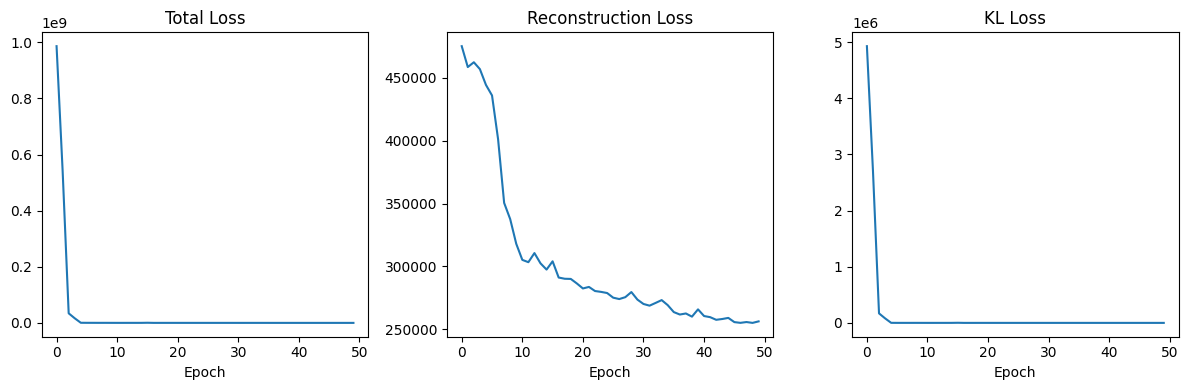

In [ ]:
# Plot loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Total Loss')
plt.xlabel('Epoch')

plt.subplot(1, 3, 2)
plt.plot(recon_losses)
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')

plt.subplot(1, 3, 3)
plt.plot(kl_losses)
plt.title('KL Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()
# plt.savefig('vae_training_losses.png')
# plt.close()

In [ ]:
# Extract features from the latent space
def extract_latent_features(model, dataloader, device):
    model.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(dataloader):
            batch = batch.to(device)
            mu, _ = model.encode(batch)
            latent_vectors.append(mu.cpu().numpy())
    
    return np.vstack(latent_vectors)

In [ ]:
# Create a new dataloader without shuffling to maintain order
eval_dataset = TensorDataset(data)
eval_dataloader = DataLoader(eval_dataset, batch_size=config['batch_size'], shuffle=False)

# Extract latent features
print("Extracting latent features...")
latent_features = extract_latent_features(model, eval_dataloader, device)
print(f"Latent features shape: {latent_features.shape}")

Extracting latent features...
Latent features shape: (1115, 16)


In [ ]:
# Dimensionality reduction using PCA for initial analysis
print("Performing PCA...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_features)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

Performing PCA...
PCA explained variance ratio: [0.2895299  0.12651512]


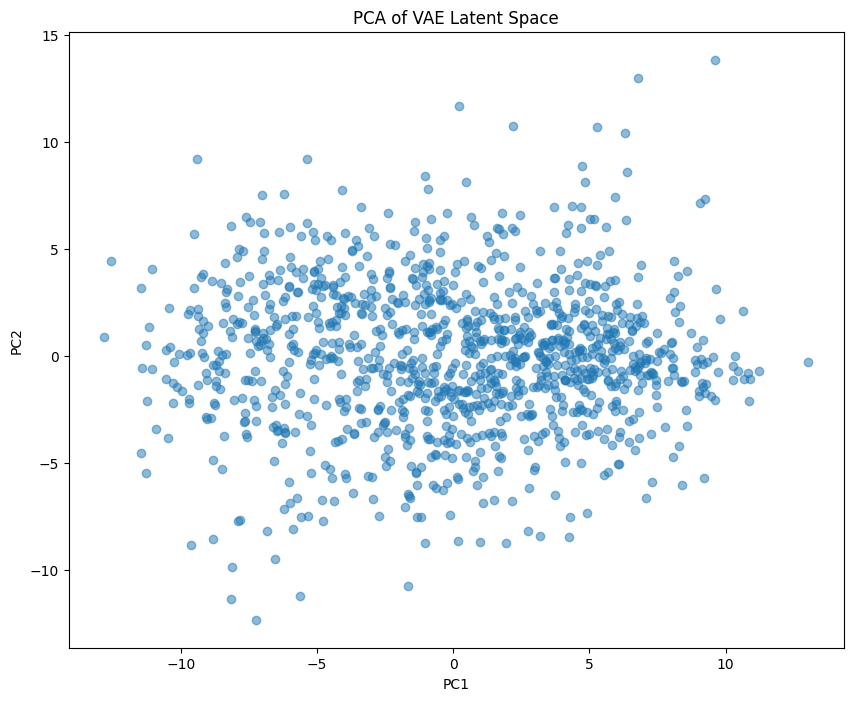

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of VAE Latent Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
# plt.savefig('pca_latent_space.png')
# plt.close()

In [ ]:
# Dimensionality reduction using UMAP
print("Performing UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent_features)

Performing UMAP...


c:\Users\BM MONEY\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


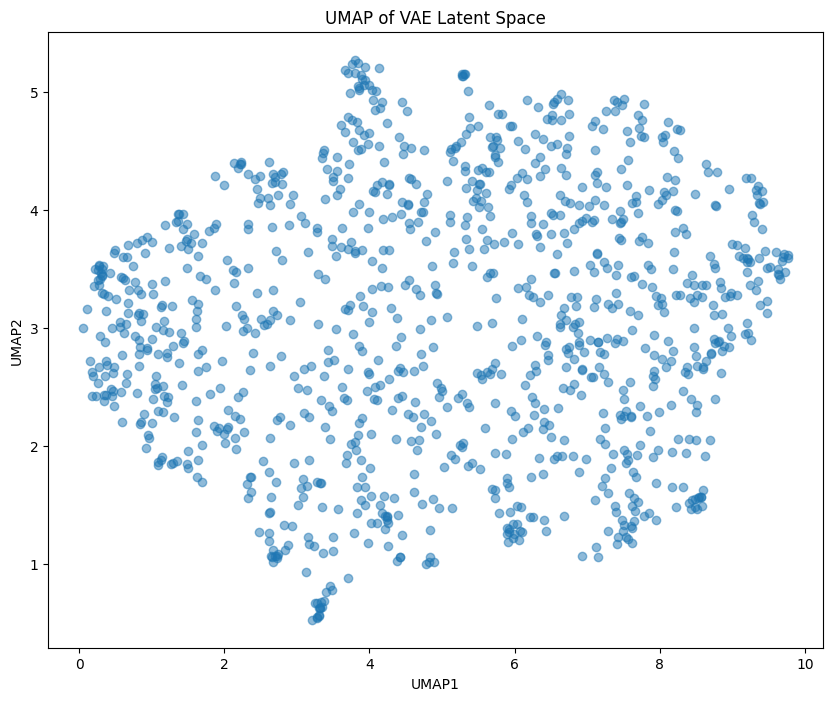

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.5)
plt.title('UMAP of VAE Latent Space')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()
# plt.savefig('umap_latent_space.png')
# plt.close()

In [ ]:
# K-Means clustering
print("Performing K-Means clustering...")
# Find optimal K using the elbow method
inertia = []
max_k = 20
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(latent_features)
    inertia.append(kmeans.inertia_)

Performing K-Means clustering...


c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

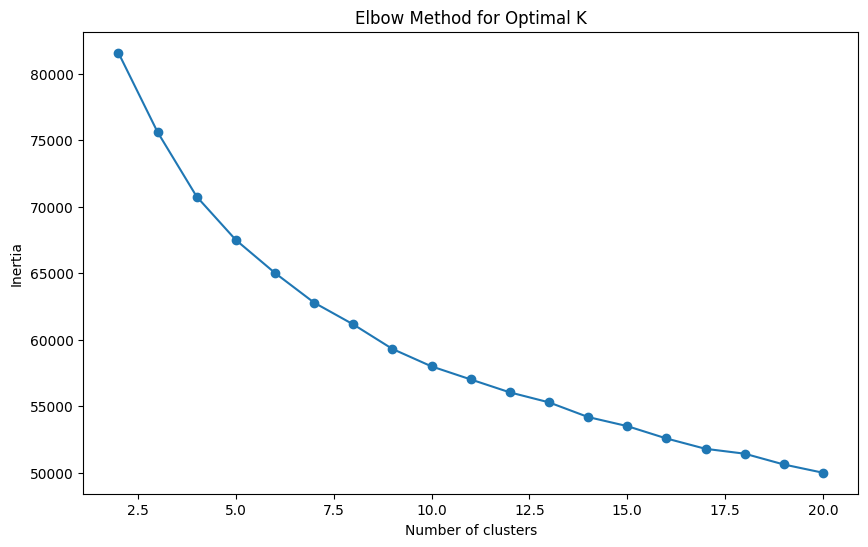

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()
# plt.savefig('kmeans_elbow.png')
# plt.close()

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(latent_features)

c:\Users\BM MONEY\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# HDBSCAN clustering
print("Performing HDBSCAN clustering...")
hdb = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5, cluster_selection_epsilon=0.5)
hdbscan_labels = hdb.fit_predict(latent_features)

Performing HDBSCAN clustering...


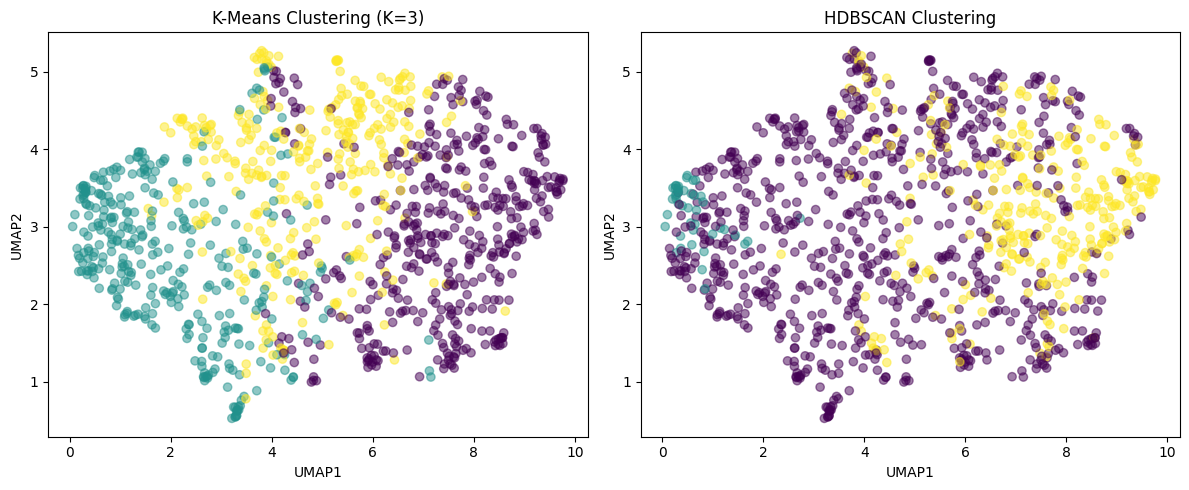

In [ ]:
# Visualize clustering results with UMAP
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1, 2, 2)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=hdbscan_labels, cmap='viridis', alpha=0.5)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.tight_layout()
plt.show()
# plt.savefig('clustering_results_umap.png')
# plt.close()


Performing t-SNE...


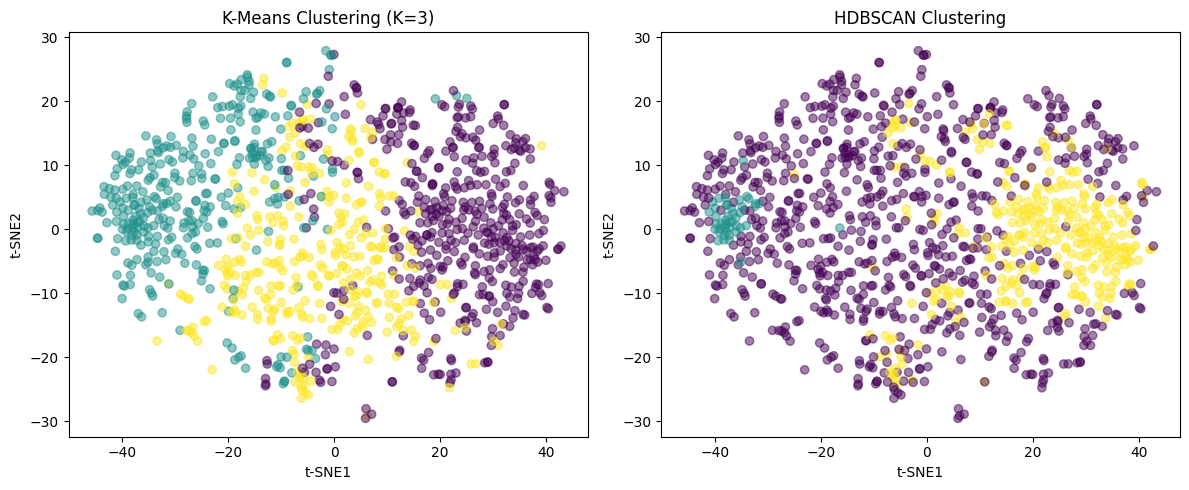

In [ ]:
# Visualize clustering results with t-SNE for comparison
print("Performing t-SNE...")
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(latent_features)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=hdbscan_labels, cmap='viridis', alpha=0.5)
plt.title('HDBSCAN Clustering')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

plt.tight_layout()
plt.show()
# plt.savefig('clustering_results_tsne.png')
# plt.close()

In [ ]:
# # Save the trained model and extracted features
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'latent_features': latent_features,
#     'kmeans_labels': kmeans_labels,
#     'hdbscan_labels': hdbscan_labels,
#     'umap_embedding': umap_result,
#     'tsne_embedding': tsne_result
# }, 'vae_clustering_results.pt')

# print("Analysis complete! Results saved to 'vae_clustering_results.pt'")

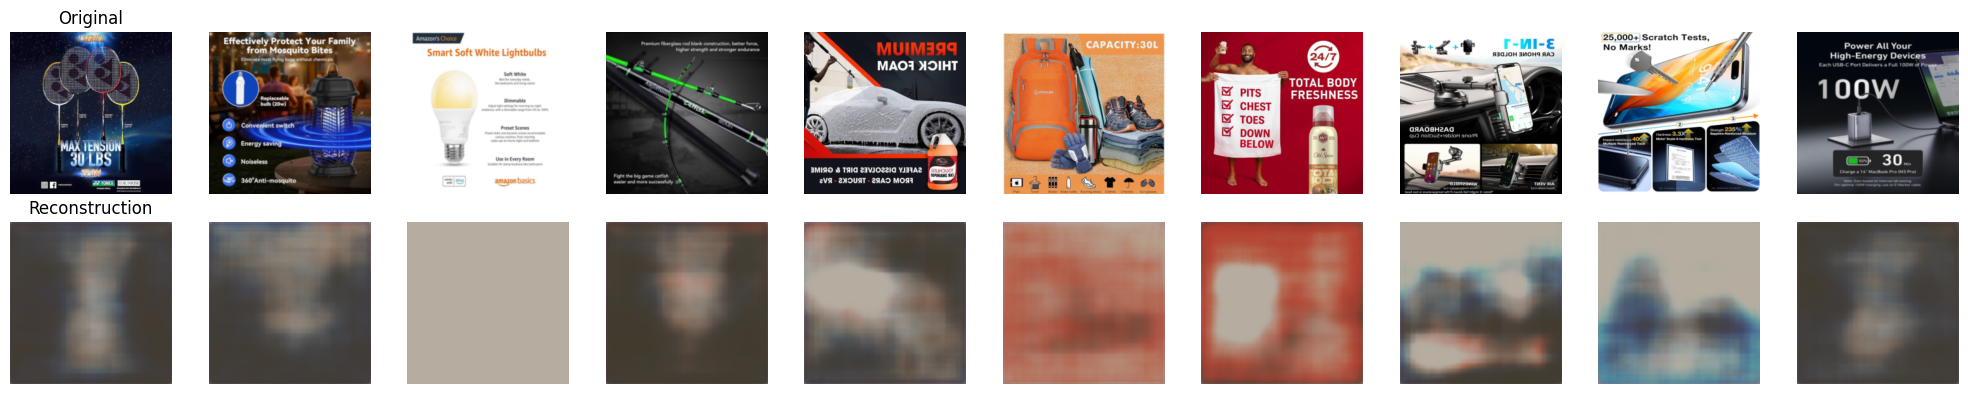

In [ ]:
# Function to visualize some reconstructed images
def visualize_reconstructions(model, dataloader, device, num_images=10):
    model.eval()
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(dataloader):
            batch = batch.to(device)
            recon_batch, _, _ = model(batch)
            
            # Denormalize images
            mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
            
            batch = batch * std + mean
            recon_batch = recon_batch * std + mean
            
            # Clamp values to be in [0, 1]
            batch = torch.clamp(batch, 0, 1)
            recon_batch = torch.clamp(recon_batch, 0, 1)
            
            # Plot some reconstructions
            plt.figure(figsize=(20, 4))
            for i in range(num_images):
                # Original
                plt.subplot(2, num_images, i + 1)
                plt.imshow(batch[i].cpu().permute(1, 2, 0))
                plt.axis('off')
                if i == 0:
                    plt.title("Original")
                
                # Reconstruction
                plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(recon_batch[i].cpu().permute(1, 2, 0))
                plt.axis('off')
                if i == 0:
                    plt.title("Reconstruction")
            
            plt.tight_layout()
            plt.show()
            # plt.savefig('reconstructions.png')
            # plt.close()
            break  # Just one batch

# Visualize some reconstructions
visualize_reconstructions(model, eval_dataloader, device)


error

In [ ]:
# # Function to save example images from each cluster
# def save_cluster_examples(data, kmeans_labels, base_folder, num_clusters, num_examples=5):
#     # Create directory to save examples
#     os.makedirs('cluster_examples', exist_ok=True)
    
#     # Denormalize images
#     mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
#     std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    
#     # Get examples for each cluster
#     for cluster_id in range(num_clusters):
#         # Get indices of images in this cluster
#         cluster_indices = np.where(kmeans_labels == cluster_id)[0]
        
#         if len(cluster_indices) > 0:
#             # Take a sample
#             sample_size = min(num_examples, len(cluster_indices))
#             sample_indices = np.random.choice(cluster_indices, sample_size, replace=False)
            
#             # Plot examples
#             plt.figure(figsize=(15, 3))
#             for i, idx in enumerate(sample_indices):
#                 img = data[idx].clone().detach()
#                 img = img * std + mean
#                 img = torch.clamp(img, 0, 1)
                
#                 plt.subplot(1, sample_size, i + 1)
#                 plt.imshow(img.cpu().permute(1, 2, 0))
#                 plt.axis('off')
            
#             plt.suptitle(f'Cluster {cluster_id} Examples')
#             plt.tight_layout()
#             plt.savefig(f'cluster_examples/cluster_{cluster_id}_examples.png')
#             plt.close()

# # Save examples from each K-Means cluster
# save_cluster_examples(data, kmeans_labels, base_folder, optimal_k)

In [ ]:
# Create a summary of clustering results
cluster_summary = {
    'kmeans': {
        'num_clusters': optimal_k,
        'cluster_sizes': [np.sum(kmeans_labels == i) for i in range(optimal_k)]
    },
    'hdbscan': {
        'num_clusters': len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0),
        'cluster_sizes': [np.sum(hdbscan_labels == i) for i in set(hdbscan_labels) if i != -1],
        'noise_points': np.sum(hdbscan_labels == -1) if -1 in hdbscan_labels else 0
    }
}

print("\nClustering Summary:")
print(f"K-Means: {cluster_summary['kmeans']['num_clusters']} clusters")
print(f"Cluster sizes: {cluster_summary['kmeans']['cluster_sizes']}")
print(f"\nHDBSCAN: {cluster_summary['hdbscan']['num_clusters']} clusters")
print(f"Cluster sizes: {cluster_summary['hdbscan']['cluster_sizes']}")
print(f"Noise points: {cluster_summary['hdbscan']['noise_points']}")


Clustering Summary:
K-Means: 3 clusters
Cluster sizes: [453, 341, 321]

HDBSCAN: 2 clusters
Cluster sizes: [44, 300]
Noise points: 771


In [ ]:
from sklearn.metrics import silhouette_score

ll = kmeans.labels_

silhouette_score(latent_features, ll)

0.14771077

In [ ]:
# # Save the clustering summary
# with open('cluster_summary.txt', 'w') as f:
#     f.write("Clustering Summary:\n")
#     f.write(f"K-Means: {cluster_summary['kmeans']['num_clusters']} clusters\n")
#     f.write(f"Cluster sizes: {cluster_summary['kmeans']['cluster_sizes']}\n\n")
#     f.write(f"HDBSCAN: {cluster_summary['hdbscan']['num_clusters']} clusters\n")
#     f.write(f"Cluster sizes: {cluster_summary['hdbscan']['cluster_sizes']}\n")
#     f.write(f"Noise points: {cluster_summary['hdbscan']['noise_points']}\n")